## Predict list image

In [3]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os
import math

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
saved_model_path = 'CheckPoints/SaveModel/saved_model_03'
# saved_model_path = 'microsoft/trocr-small-printed'
model = VisionEncoderDecoderModel.from_pretrained(saved_model_path).to(device)
processor = TrOCRProcessor.from_pretrained(saved_model_path)

In [6]:
def read_and_show(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model):
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [7]:
def visualize_images(image_paths):
    num_images = len(image_paths)
    num_cols = 5
    num_rows = math.ceil(num_images / num_cols)
    
    plt.figure(figsize=(15, num_rows * 3))
    for i, image_path in enumerate(image_paths):
        plt.subplot(num_rows, num_cols, i + 1)
        image = read_and_show(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(os.path.basename(image_path))
    plt.show()

In [8]:
def predict_and_save(image_paths, output_file='ImagesTest.txt'):
    results = []
    for image_path in image_paths:
        try:
            image = read_and_show(image_path)
            text = ocr(image, processor, model)
            results.append((image_path, text))
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    # Hiển thị kết quả dự đoán trong một grid
    num_images = len(results)
    num_cols = 5
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(15, num_rows * 3))
    for i, (image_path, text) in enumerate(results):
        plt.subplot(num_rows, num_cols, i + 1)
        image = read_and_show(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.title(text)
    plt.show()

    # Lưu kết quả vào file text với định dạng sử dụng tab
    with open(output_file, 'w') as f:
        for image_path, text in results:
            f.write(f"{image_path}\t{text}\n")

    print(f"Saved predictions to {output_file}")

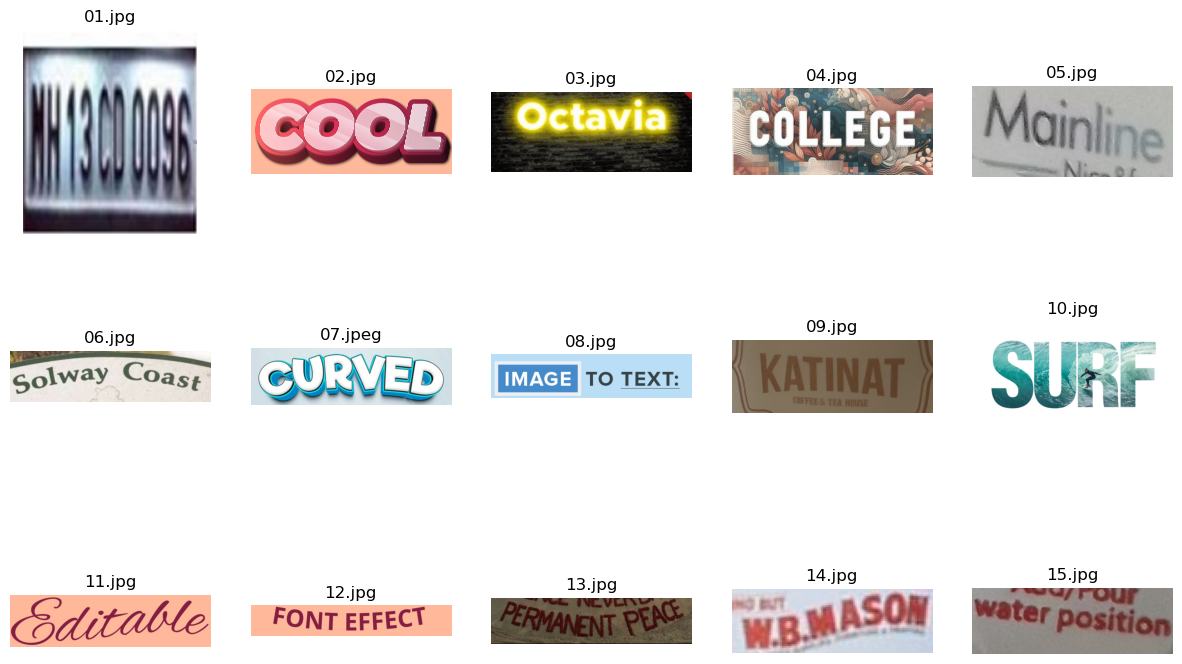

In [9]:
new_data_path = 'ImageTest'
image_paths = [os.path.join(new_data_path, img) for img in os.listdir(new_data_path) if img.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif', 'tif', 'tiff'))]
visualize_images(image_paths)

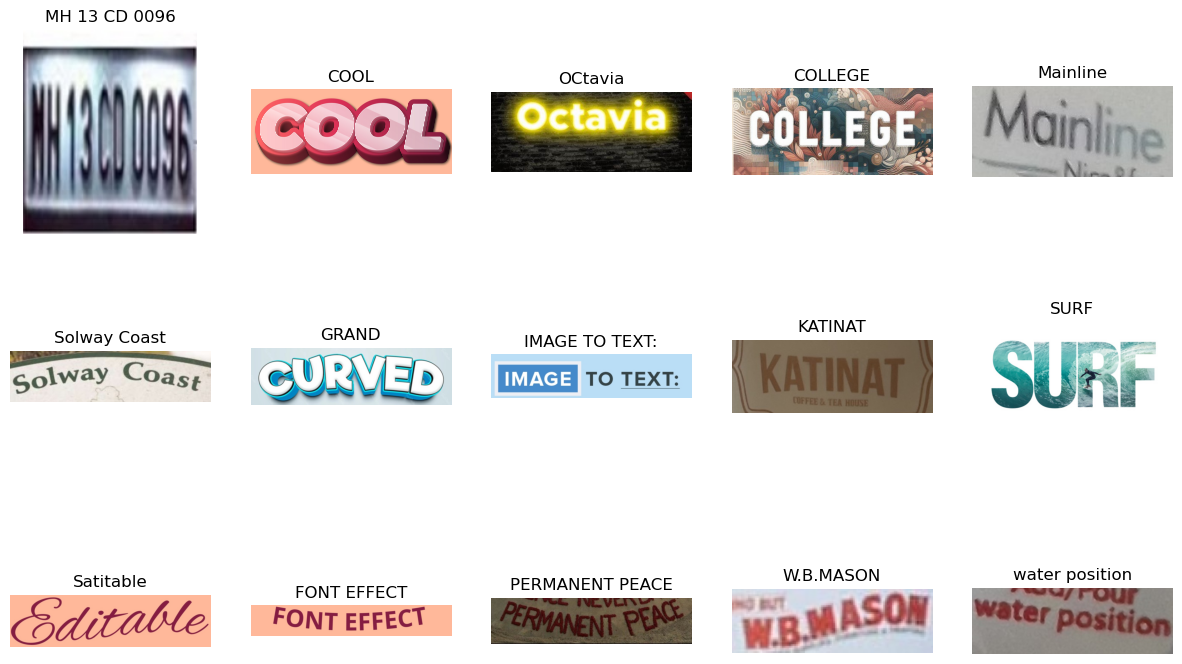

Saved predictions to ImageTest/ImagesTest.txt


In [10]:
predict_and_save(image_paths, output_file='ImageTest/ImagesTest.txt')

In [11]:
import pandas as pd
file_path = os.path.join('ImageTest', 'ImagesTest.txt')
df = pd.read_csv(file_path, sep='\t', header=None, names=['file_name', 'text'])

df.head()

,file_name,text
0,ImageTest\01.jpg,MH 13 CD 0096
1,ImageTest\02.jpg,COOL
2,ImageTest\03.jpg,OCtavia
3,ImageTest\04.jpg,COLLEGE
4,ImageTest\05.jpg,Mainline


In [22]:
def load_ground_truth(file_path):
    with open(file_path, 'r') as f:
        ground_truth = {}
        for line in f:
            parts = line.strip().split('\t', 1)
            if len(parts) == 2:
                image_name, text = parts
                ground_truth[image_name.strip()] = text.strip()
            else:
                print(f"Warning: Skipping invalid line in {file_path}: {line.strip()}")
    return ground_truth

In [23]:
def calculate_accuracy(predictions_file, ground_truth_file):
    predictions = load_ground_truth(predictions_file)
    ground_truth = load_ground_truth(ground_truth_file)

    correct_predictions = 0
    total_predictions = len(ground_truth)

    incorrect_examples = []

    for image_name, true_text in ground_truth.items():
        predicted_text = predictions.get(image_name, "")
        if predicted_text.strip() == true_text.strip():
            correct_predictions += 1
        else:
            incorrect_examples.append((image_name, true_text, predicted_text))

    accuracy = correct_predictions / total_predictions
    return accuracy, incorrect_examples

In [24]:
def plot_accuracy(accuracy, incorrect_examples):
    labels = ['Dự đoán đúng', 'Dự đoán sai']
    sizes = [accuracy * 100, (1 - accuracy) * 100]
    colors = ['#3772ff', '#e63946']

    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
                                       textprops={'color': 'white', 'fontsize': 14})

    plt.legend(wedges, labels, title="Chú thích", loc='upper left', bbox_to_anchor=(0.8, 1))

    plt.title('Độ chính xác của mô hình', fontsize=16)
    plt.show()

    if incorrect_examples:
        print("\nVí dụ về các Dự đoán Sai:")
        for image_name, true_text, predicted_text in incorrect_examples:
            print(f"Hình ảnh: {image_name}\nKết quả đúng: {true_text}\nKết quả dự đoán: {predicted_text}\n")

Accuracy: 80.00%


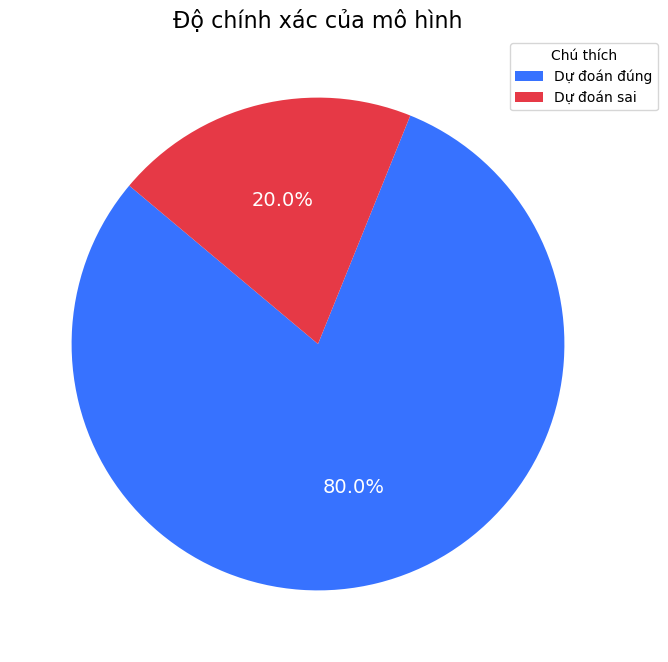


Ví dụ về các Dự đoán Sai:
Hình ảnh: ImageTest\03.jpg
Kết quả đúng: Octavia
Kết quả dự đoán: OCtavia

Hình ảnh: ImageTest\07.jpeg
Kết quả đúng: CURVED
Kết quả dự đoán: GRAND

Hình ảnh: ImageTest\11.jpg
Kết quả đúng: Editable
Kết quả dự đoán: Satitable



In [25]:
accuracy, incorrect_examples = calculate_accuracy('ImageTest/ImagesTest.txt', 'ImageTest/ImagesTest_True.txt')
print(f"Accuracy: {accuracy * 100:.2f}%")
plot_accuracy(accuracy, incorrect_examples)

In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from jiwer import cer, wer
import difflib
import matplotlib.pyplot as plt

def load_ground_truth(file_path):
    with open(file_path, 'r') as f:
        ground_truth = {}
        for line in f:
            parts = line.strip().split(': ', 1)
            if len(parts) == 2:
                image_name, text = parts
                ground_truth[image_name.strip()] = text.strip()
    return ground_truth

def load_predictions(file_path):
    with open(file_path, 'r') as f:
        predictions = {}
        for line in f:
            parts = line.strip().split(': ', 1)
            if len(parts) == 2:
                image_name, text = parts
                predictions[image_name.strip()] = text.strip()
    return predictions

In [15]:
def calculate_accuracy(predictions, ground_truth):
    correct_predictions = 0
    total_predictions = len(ground_truth)

    for image_name, true_text in ground_truth.items():
        predicted_text = predictions.get(image_name, "")
        if predicted_text.strip() == true_text.strip():
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_precision_recall_f1(predictions, ground_truth):
    y_true = []
    y_pred = []

    for image_name, true_text in ground_truth.items():
        y_true.append(true_text)
        y_pred.append(predictions.get(image_name, ""))

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return precision, recall, f1

def calculate_cer_wer(predictions, ground_truth):
    cer_scores = []
    wer_scores = []

    for image_name, true_text in ground_truth.items():
        predicted_text = predictions.get(image_name, "")
        cer_scores.append(cer(true_text, predicted_text))
        wer_scores.append(wer(true_text, predicted_text))

    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)

    return avg_cer, avg_wer

def calculate_edit_distance(predictions, ground_truth):
    distances = []

    for image_name, true_text in ground_truth.items():
        predicted_text = predictions.get(image_name, "")
        distance = difflib.ndiff(true_text, predicted_text)
        distances.append(sum(1 for _ in distance if _.startswith('-') or _.startswith('+')))

    avg_distance = np.mean(distances)
    return avg_distance

In [16]:
def plot_metrics(accuracy, precision, recall, f1, cer, wer, edit_distance):
    metrics = {
        'Độ chính xác (Accuracy)': accuracy * 100,
        'Độ chính xác (Precision)': precision * 100,
        'Độ nhạy (Recall)': recall * 100,
        'F1-Score': f1 * 100,
        'Character Error Rate (CER)': cer * 100,
        'Word Error Rate (WER)': wer * 100,
        'Edit Distance': edit_distance
    }
    
    plt.figure(figsize=(12, 8))

    plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
    plt.xlabel('Giá trị')
    plt.title('Kết quả đánh giá mô hình OCR')

    for index, value in enumerate(metrics.values()):
        plt.text(value, index, f'{value:.2f}', va='center')

    plt.tight_layout()
    plt.show()

In [17]:
# Đường dẫn đến các tệp
predictions_file = 'LISTIMAGETEST/Predict_LISTIMAGETEST.txt'
ground_truth_file = 'LISTIMAGETEST/Result_LISTIMAGETEST_True.txt'

# Tải dữ liệu
predictions = load_predictions(predictions_file)
ground_truth = load_ground_truth(ground_truth_file)

In [18]:
# Tính toán các chỉ số
accuracy = calculate_accuracy(predictions, ground_truth)
precision, recall, f1 = calculate_precision_recall_f1(predictions, ground_truth)
cer, wer = calculate_cer_wer(predictions, ground_truth)
edit_distance = calculate_edit_distance(predictions, ground_truth)

In [19]:
# In kết quả
print(f"Độ chính xác (Accuracy): {accuracy * 100:.2f}%")
print(f"Độ chính xác (Precision): {precision:.2f}")
print(f"Độ nhạy (Recall): {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Character Error Rate (CER): {cer:.2f}")
print(f"Word Error Rate (WER): {wer:.2f}")
print(f"Edit Distance: {edit_distance:.2f}")

Độ chính xác (Accuracy): 88.00%
Độ chính xác (Precision): 0.88
Độ nhạy (Recall): 0.88
F1-Score: 0.88
Character Error Rate (CER): 0.06
Word Error Rate (WER): 0.12
Edit Distance: 0.76


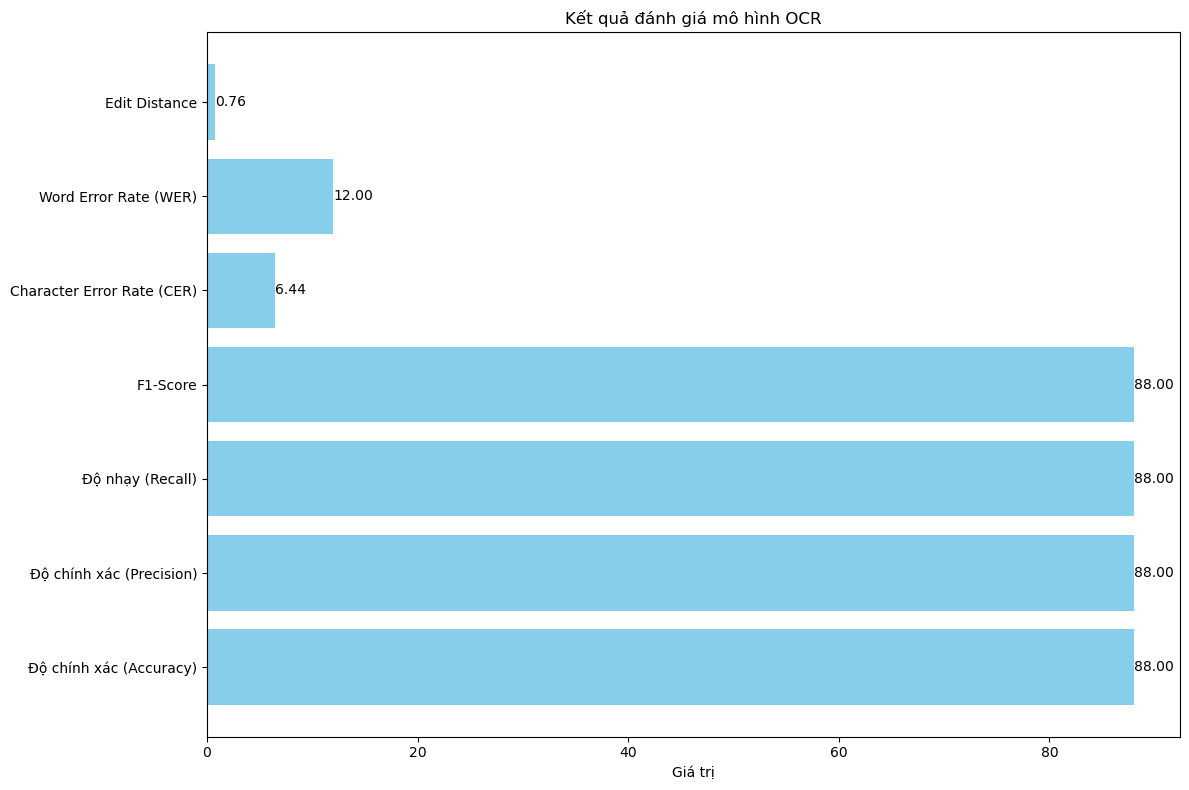

In [20]:
# Vẽ biểu đồ
plot_metrics(accuracy, precision, recall, f1, cer, wer, edit_distance)

## Predict each image

In [2]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Tải lại mô hình và processor đã huấn luyện

In [4]:
saved_model_path = 'CheckPoints/SaveModel/saved_model_03/'
model = VisionEncoderDecoderModel.from_pretrained(saved_model_path).to(device)
processor = TrOCRProcessor.from_pretrained(saved_model_path)

### Đọc, hiển thị kết quả nhận dạng

In [5]:
def read_and_show(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model):
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [6]:
def predict_image(image_path):
    try:
        image = read_and_show(image_path)
        text = ocr(image, processor, model)

        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

        file_name = os.path.basename(image_path)
        output_txt_path = os.path.join('Predict', f"{os.path.splitext(file_name)[0]}.txt")

        with open(output_txt_path, 'w') as f:
            f.write(text)

        return text
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

### Truyền hình ảnh để dự đoán 

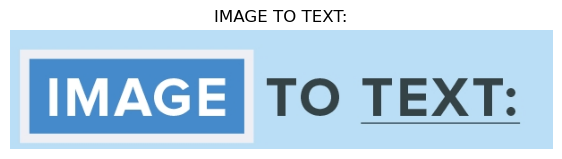

Predicted text for ImageTest/08.jpg: IMAGE TO TEXT:


In [6]:
image_path = 'ImageTest/08.jpg'

predicted_text = predict_image(image_path)
print(f"Predicted text for {image_path}: {predicted_text}")

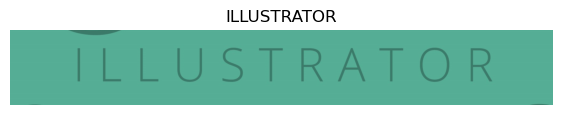

Predicted text for ImageTest/16.jpg: ILLUSTRATOR


In [15]:
image_path = 'ImageTest/16.jpg'

predicted_text = predict_image(image_path)
print(f"Predicted text for {image_path}: {predicted_text}")

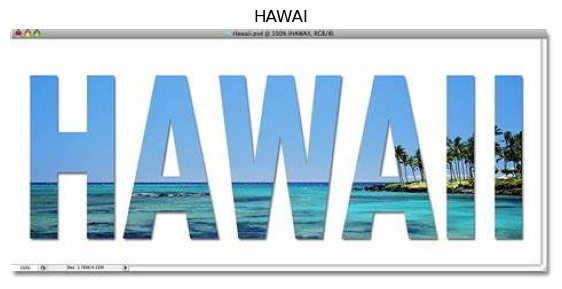

Predicted text for ImageTest/19.jfif: HAWAI


In [27]:
image_path = 'ImageTest/19.jfif'

predicted_text = predict_image(image_path)
print(f"Predicted text for {image_path}: {predicted_text}")

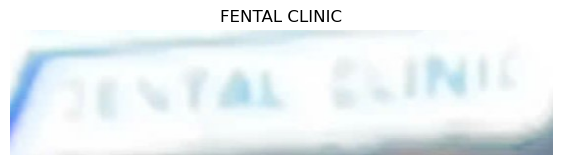

Predicted text for ImageTest/20.jpg: FENTAL CLINIC


In [8]:
image_path = 'ImageTest/20.jpg'

predicted_text = predict_image(image_path)
print(f"Predicted text for {image_path}: {predicted_text}")

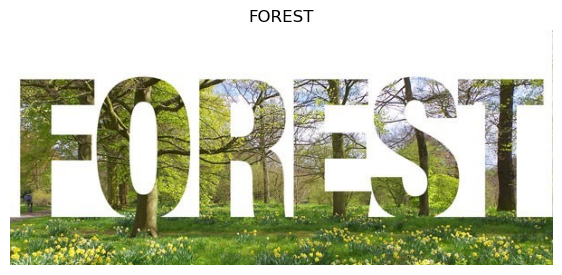

Predicted text for ImageTest/22.1.jpg: FOREST


In [11]:
image_path = 'ImageTest/22.1.jpg'

predicted_text = predict_image(image_path)
print(f"Predicted text for {image_path}: {predicted_text}")